In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
def rnn_weight_init(module):
    with torch.no_grad():
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'bias_ih' in name:
                param.data.fill_(1)
            elif 'bias_hh' in name:
                param.data.fill_(0)

def linear_weight_init(module):
    with torch.no_grad():
        for name, param in module.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                param.data.fill_(0)

In [3]:
class EmbeddingNetwork(nn.Module):

    def __init__(self, feature_dim, hidden_dim, num_layers, padding_value, max_seq_len):
        super().__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len

        self.emb_rnn = nn.GRU(
            input_size=self.feature_dim, 
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.emb_linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.emb_sigmoid = nn.Sigmoid()

        rnn_weight_init(self.emb_rnn)
        linear_weight_init(self.emb_linear)
    
    def forward(self, X, T):
        X_packed = nn.utils.rnn.pack_padded_sequence(
            input=X, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )

        H_o, H_t = self.emb_rnn(X_packed)
        H_o, T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        logits = self.emb_linear(H_o)
        H = self.emb_sigmoid(logits)
        return H


In [4]:
class RecoveryNetwork(nn.Module):
    """The recovery network (decoder) for TimeGAN
    """
    def __init__(self, feature_dim, hidden_dim, num_layers, padding_value, max_seq_len):
        super().__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len
        
        self.rec_rnn = nn.GRU(
            input_size=self.hidden_dim, 
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.rec_linear = torch.nn.Linear(self.hidden_dim, self.feature_dim)
        rnn_weight_init(self.rec_rnn)
        linear_weight_init(self.rec_linear)
    
    def forward(self, H, T):
        H_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=H, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 10
        H_o, H_t = self.rec_rnn(H_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100 x 71
        X_tilde = self.rec_linear(H_o)
        return X_tilde

In [5]:
class SupervisorNetwork(torch.nn.Module):
    """The Supervisor network (decoder) for TimeGAN
    """
    def __init__(self, hidden_dim, num_layers, padding_value, max_seq_len):
        super(SupervisorNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len

        # Supervisor Architecture
        self.sup_rnn = torch.nn.GRU(
            input_size=self.hidden_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers-1,
            batch_first=True
        )
        self.sup_linear = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sup_sigmoid = torch.nn.Sigmoid()
        rnn_weight_init(self.sup_rnn)
        linear_weight_init(self.sup_linear)
        

    def forward(self, H, T):
        """Forward pass for the supervisor for predicting next step
        Args:
            - H: latent representation (B x S x E)
            - T: input temporal information (B)
        Returns:
            - H_hat: predicted next step data (B x S x E)
        """
        # Dynamic RNN input for ignoring paddings
        H_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=H, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 10
        H_o, H_t = self.sup_rnn(H_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100 x 10
        logits = self.sup_linear(H_o)
        # 128 x 100 x 10
        H_hat = self.sup_sigmoid(logits)
        return H_hat


In [6]:
class GeneratorNetwork(torch.nn.Module):
    """The generator network (encoder) for TimeGAN
    """
    def __init__(self, Z_dim, hidden_dim, num_layers, padding_value, max_seq_len):
        super(GeneratorNetwork, self).__init__()
        self.Z_dim = Z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len

        # Generator Architecture
        self.gen_rnn = torch.nn.GRU(
            input_size=self.Z_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.gen_linear = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.gen_sigmoid = torch.nn.Sigmoid()
        rnn_weight_init(self.gen_rnn)
        linear_weight_init(self.gen_linear)

    def forward(self, Z, T):
        """Takes in random noise (features) and generates synthetic features within the latent space
        Args:
            - Z: input random noise (B x S x Z)
            - T: input temporal information
        Returns:
            - H: embeddings (B x S x E)
        """
        # Dynamic RNN input for ignoring paddings
        Z_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=Z, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 71
        H_o, H_t = self.gen_rnn(Z_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100 x 10
        logits = self.gen_linear(H_o)
        # B x S
        H = self.gen_sigmoid(logits)
        return H

In [7]:
class DiscriminatorNetwork(torch.nn.Module):
    """The Discriminator network (decoder) for TimeGAN
    """
    def __init__(self, hidden_dim, num_layers, padding_value, max_seq_len):
        super(DiscriminatorNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len

        # Discriminator Architecture
        self.dis_rnn = torch.nn.GRU(
            input_size=self.hidden_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.dis_linear = torch.nn.Linear(self.hidden_dim, 1)
        rnn_weight_init(self.dis_rnn)
        linear_weight_init(self.dis_linear)

    def forward(self, H, T):
        """Forward pass for predicting if the data is real or synthetic
        Args:
            - H: latent representation (B x S x E)
            - T: input temporal information
        Returns:
            - logits: predicted logits (B x S x 1)
        """
        # Dynamic RNN input for ignoring paddings
        H_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=H, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 10
        H_o, H_t = self.dis_rnn(H_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100
        logits = self.dis_linear(H_o).squeeze(-1)
        return logits

In [8]:
class TimeGAN(torch.nn.Module):
    """Implementation of TimeGAN (Yoon et al., 2019) using PyTorch\n
    Reference:
    - https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html
    - https://github.com/jsyoon0823/TimeGAN
    """
    def __init__(self, feature_dim, hidden_dim, num_layers, padding_value, Z_dim, max_seq_len, batch_size, device):
        super(TimeGAN, self).__init__()
        self.device = device
        self.feature_dim = feature_dim
        self.Z_dim = Z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size

        self.embedder = EmbeddingNetwork(feature_dim, hidden_dim, num_layers, padding_value, max_seq_len)
        self.recovery = RecoveryNetwork(feature_dim, hidden_dim, num_layers, padding_value, max_seq_len)
        self.generator = GeneratorNetwork(Z_dim, hidden_dim, num_layers, padding_value, max_seq_len)
        self.supervisor = SupervisorNetwork(hidden_dim, num_layers, padding_value, max_seq_len)
        self.discriminator = DiscriminatorNetwork(hidden_dim, num_layers, padding_value, max_seq_len)

    def _recovery_forward(self, X, T):
        """The embedding network forward pass and the embedder network loss
        Args:
            - X: the original input features
            - T: the temporal information
        Returns:
            - E_loss: the reconstruction loss
            - X_tilde: the reconstructed features
        """
        # Forward Pass
        H = self.embedder(X, T)
        X_tilde = self.recovery(H, T)

        # For Joint training
        H_hat_supervise = self.supervisor(H, T)
        G_loss_S = torch.nn.functional.mse_loss(
            H_hat_supervise[:,:-1,:], 
            H[:,1:,:]
        ) # Teacher forcing next output

        # Reconstruction Loss
        E_loss_T0 = torch.nn.functional.mse_loss(X_tilde, X)
        E_loss0 = 10 * torch.sqrt(E_loss_T0)
        E_loss = E_loss0 + 0.1 * G_loss_S
        return E_loss, E_loss0, E_loss_T0

    def _supervisor_forward(self, X, T):
        """The supervisor training forward pass
        Args:
            - X: the original feature input
        Returns:
            - S_loss: the supervisor's loss
        """
        # Supervision Forward Pass
        H = self.embedder(X, T)
        H_hat_supervise = self.supervisor(H, T)

        # Supervised loss
        S_loss = torch.nn.functional.mse_loss(H_hat_supervise[:,:-1,:], H[:,1:,:])        # Teacher forcing next output
        return S_loss

    def _discriminator_forward(self, X, T, Z, gamma=1):
        """The discriminator forward pass and adversarial loss
        Args:
            - X: the input features
            - T: the temporal information
            - Z: the input noise
        Returns:
            - D_loss: the adversarial loss
        """
        # Real
        H = self.embedder(X, T).detach()
        
        # Generator
        E_hat = self.generator(Z, T).detach()
        H_hat = self.supervisor(E_hat, T).detach()

        # Forward Pass
        Y_real = self.discriminator(H, T)            # Encoded original data
        Y_fake = self.discriminator(H_hat, T)        # Output of generator + supervisor
        Y_fake_e = self.discriminator(E_hat, T)      # Output of generator

        D_loss_real = torch.nn.functional.binary_cross_entropy_with_logits(Y_real, torch.ones_like(Y_real))
        D_loss_fake = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake, torch.zeros_like(Y_fake))
        D_loss_fake_e = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake_e, torch.zeros_like(Y_fake_e))

        D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e

        return D_loss

    def _generator_forward(self, X, T, Z, gamma=1):
        """The generator forward pass
        Args:
            - X: the original feature input
            - T: the temporal information
            - Z: the noise for generator input
        Returns:
            - G_loss: the generator's loss
        """
        # Supervisor Forward Pass
        H = self.embedder(X, T)
        H_hat_supervise = self.supervisor(H, T)

        # Generator Forward Pass
        E_hat = self.generator(Z, T)
        H_hat = self.supervisor(E_hat, T)

        # Synthetic data generated
        X_hat = self.recovery(H_hat, T)

        # Generator Loss
        # 1. Adversarial loss
        Y_fake = self.discriminator(H_hat, T)        # Output of supervisor
        Y_fake_e = self.discriminator(E_hat, T)      # Output of generator

        G_loss_U = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))
        G_loss_U_e = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e))

        # 2. Supervised loss
        G_loss_S = torch.nn.functional.mse_loss(H_hat_supervise[:,:-1,:], H[:,1:,:])        # Teacher forcing next output

        # 3. Two Momments
        G_loss_V1 = torch.mean(torch.abs(torch.sqrt(X_hat.var(dim=0, unbiased=False) + 1e-6) - torch.sqrt(X.var(dim=0, unbiased=False) + 1e-6)))
        G_loss_V2 = torch.mean(torch.abs((X_hat.mean(dim=0)) - (X.mean(dim=0))))

        G_loss_V = G_loss_V1 + G_loss_V2

        # 4. Summation
        G_loss = G_loss_U + gamma * G_loss_U_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V

        return G_loss

    def _inference(self, Z, T):
        """Inference for generating synthetic data
        Args:
            - Z: the input noise
            - T: the temporal information
        Returns:
            - X_hat: the generated data
        """
        # Generator Forward Pass
        E_hat = self.generator(Z, T)
        H_hat = self.supervisor(E_hat, T)

        # Synthetic data generated
        X_hat = self.recovery(H_hat, T)
        return X_hat

    def forward(self, X, T, Z, obj, gamma=1):
        """
        Args:
            - X: the input features (B, H, F)
            - T: the temporal information (B)
            - Z: the sampled noise (B, H, Z)
            - obj: the network to be trained (`autoencoder`, `supervisor`, `generator`, `discriminator`)
            - gamma: loss hyperparameter
        Returns:
            - loss: The loss for the forward pass
            - X_hat: The generated data
        """
        if obj != "inference":
            if X is None:
                raise ValueError("`X` should be given")

            X = torch.FloatTensor(X)
            X = X.to(self.device)

        if Z is not None:
            Z = torch.FloatTensor(Z)
            Z = Z.to(self.device)

        if obj == "autoencoder":
            # Embedder & Recovery
            loss = self._recovery_forward(X, T)

        elif obj == "supervisor":
            # Supervisor
            loss = self._supervisor_forward(X, T)

        elif obj == "generator":
            if Z is None:
                raise ValueError("`Z` is not given")

            # Generator
            loss = self._generator_forward(X, T, Z)

        elif obj == "discriminator":
            if Z is None:
                raise ValueError("`Z` is not given")
            
            # Discriminator
            loss = self._discriminator_forward(X, T, Z)
            
            return loss

        elif obj == "inference":

            X_hat = self._inference(Z, T)
            X_hat = X_hat.cpu().detach()

            return X_hat

        else: raise ValueError("`obj` should be either `autoencoder`, `supervisor`, `generator`, or `discriminator`")

        return loss

In [9]:
from sktime.datasets import base, load_UCR_UEA_dataset
class TimeGANDataset(torch.utils.data.Dataset):
    """TimeGAN Dataset for sampling data with their respective time
    Args:
        - data (numpy.ndarray): the padded dataset to be fitted (D x S x F)
        - time (numpy.ndarray): the length of each data (D)
    Parameters:
        - x (torch.FloatTensor): the real value features of the data
        - t (torch.LongTensor): the temporal feature of the data 
    """
    def __init__(self, name, split, padding_value=None):
        # sanity check
        self.X, self.Y = load_UCR_UEA_dataset(name, split=split, return_X_y=True)
        self.X = [torch.tensor(self.X.iloc[i]).transpose(0, 1) for i in range(len(self.X))]
        self.T = [x.size(0) for x in self.X]


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.T[idx]

    def collate_fn(self, batch):
        """Minibatch sampling
        """
        # Pad sequences to max length
        X_mb = [X for X in batch[0]]
        
        # The actual length of each data
        T_mb = [T for T in batch[1]]
        
        return X_mb, T_mb

In [10]:
from tqdm import trange

def embedding_trainer(model, dataloader, e_opt, r_opt, n_epochs):
    logger = trange(n_epochs, desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            model.zero_grad()

            _, E_loss0, E_loss_T0 = model(X=X_mb, T=T_mb, Z=None, obj="autoencoder")
            loss = np.sqrt(E_loss_T0.item())

            E_loss0.backward()
            e_opt.step()
            r_opt.step()
        
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")

def supervisor_trainer(model, dataloader, s_opt, g_opt, n_epochs):
    logger = trange(n_epochs, desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            model.zero_grad()

            S_loss = model(X=X_mb, T=T_mb, Z=None, obj="supervisor")
            loss = np.sqrt(S_loss.item())

            S_loss.backward()
            s_opt.step()
        
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")


def joint_trainer(model, dataloader, e_opt, r_opt, s_opt, g_opt, d_opt, n_epochs, batch_size, max_seq_len, Z_dim, \
    dis_thresh):
    logger = trange(n_epochs, desc=f"Epoch: 0, E_loss: 0, G_loss: 0, D_loss: 0")
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            for _ in range(2):
                Z_mb = torch.rand(batch_size, max_seq_len, Z_dim)
                model.zero_grad()
                # Generator
                G_loss = model(X=X_mb, T=T_mb, Z=Z_mb, obj="generator")
                G_loss.backward()
                G_loss = np.sqrt(G_loss.item())

                g_opt.step()
                s_opt.step()

                # Embeding
                model.zero_grad()
                E_loss, _, E_loss_T0 = model(X=X_mb, T=T_mb, Z=Z_mb, obj="autoencoder")
                E_loss.backward()
                E_loss = np.sqrt(E_loss.item())

                e_opt.step()
                r_opt.step()
            
            Z_mb = torch.rand((batch_size, max_seq_len, Z_dim))
            model.zero_grad()
            D_loss = model(X=X_mb, T=T_mb, Z=Z_mb, obj="discriminator")
            if D_loss > dis_thresh:
                D_loss.backward()
                d_opt.step()
            D_loss = D_loss.item()

        logger.set_description(
            f"Epoch: {epoch}, E: {E_loss:.4f}, G: {G_loss:.4f}, D: {D_loss:.4f}"
        )


def timegan_trainer(model, dataset, batch_size, device, learning_rate, n_epochs, max_seq_len, dis_thresh):
    """The training procedure for TimeGAN
    Args:
        - model (torch.nn.module): The model model that generates synthetic data
        - data (numpy.ndarray): The data for training the model
        - time (numpy.ndarray): The time for the model to be conditioned on
        - args (dict): The model/training configurations
    Returns:
        - generated_data (np.ndarray): The synthetic data generated by the model
    """

    # Initialize TimeGAN dataset and dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True    
    )

    model.to(device)

    # Initialize Optimizers
    e_opt = torch.optim.Adam(model.embedder.parameters(), lr=learning_rate)
    r_opt = torch.optim.Adam(model.recovery.parameters(), lr=learning_rate)
    s_opt = torch.optim.Adam(model.supervisor.parameters(), lr=learning_rate)
    g_opt = torch.optim.Adam(model.generator.parameters(), lr=learning_rate)
    d_opt = torch.optim.Adam(model.discriminator.parameters(), lr=learning_rate)

    print("\nStart Embedding Network Training")
    embedding_trainer(
        model=model, 
        dataloader=dataloader, 
        e_opt=e_opt, 
        r_opt=r_opt, 
        n_epochs=n_epochs
    )

    print("\nStart Training with Supervised Loss Only")
    supervisor_trainer(
        model=model,
        dataloader=dataloader,
        s_opt=s_opt,
        g_opt=g_opt,
        n_epochs=n_epochs,
    )

    print("\nStart Joint Training")
    joint_trainer(
        model=model,
        dataloader=dataloader,
        e_opt=e_opt,
        r_opt=r_opt,
        s_opt=s_opt,
        g_opt=g_opt,
        d_opt=d_opt,
        n_epochs=n_epochs,
        batch_size=batch_size,
        max_seq_len=max_seq_len,
        Z_dim=100,
        dis_thresh=dis_thresh
    )

    # Save model, args, and hyperparameters
    torch.save(model.state_dict(), "model.pt")

def timegan_generator(model, T, model_path, device, max_seq_len, Z_dim):
    """The inference procedure for TimeGAN
    Args:
        - model (torch.nn.module): The model model that generates synthetic data
        - T (List[int]): The time to be generated on
        - args (dict): The model/training configurations
    Returns:
        - generated_data (np.ndarray): The synthetic data generated by the model
    """
    # Load model for inference
    
    model.load_state_dict(torch.load(model_path))
    
    print("\nGenerating Data...")
    # Initialize model to evaluation mode and run without gradients
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Generate fake data
        Z = torch.rand((len(T), max_seq_len, Z_dim))
        
        generated_data = model(X=None, T=T, Z=Z, obj="inference")

    return generated_data.numpy()

## train

In [20]:
trainset = TimeGANDataset("HandMovementDirection", split="train")
testset = TimeGANDataset("HandMovementDirection", split="test")
print(len(trainset), len(testset))
print(trainset[0][0].size())

160 74
torch.Size([400, 10])


In [21]:
# trainset = TimeGANDataset("BasicMotions", split="train")
# testset = TimeGANDataset("AtrialFibrillation", split="test")
feature_dim = trainset[0][0].size(1)
model = TimeGAN(feature_dim=feature_dim, \
    hidden_dim=20, 
    num_layers=3, 
    padding_value=0., 
    Z_dim=100, 
    max_seq_len=trainset[0][0].size(0), 
    batch_size=64, 
    device=torch.device("cuda"))

timegan_trainer(model, \
    trainset, 
    batch_size=64, 
    device=torch.device("cuda"), 
    learning_rate=0.001, 
    n_epochs=600,
    max_seq_len=trainset[0][0].size(0),
    dis_thresh=0.15
    )


Start Embedding Network Training


Epoch: 599, Loss: 143.3054: 100%|██████████| 600/600 [02:18<00:00,  4.34it/s]



Start Training with Supervised Loss Only


Epoch: 599, Loss: 0.1715: 100%|██████████| 600/600 [01:46<00:00,  5.62it/s]



Start Joint Training


Epoch: 22, E: 38.4180, G: 124.9130, D: 1.8683:   4%|▍         | 23/600 [00:57<23:55,  2.49s/it]


KeyboardInterrupt: 

In [13]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device("cuda"), testset[0][0].size(0), 100)


Generating Data...


In [14]:
gen_z.shape

(138, 206, 3)

In [33]:
gen_z_t = timegan_generator(model, torch.tensor(trainset.T), "model.pt", torch.device("cuda"), trainset[0][0].size(0), 100)


Generating Data...


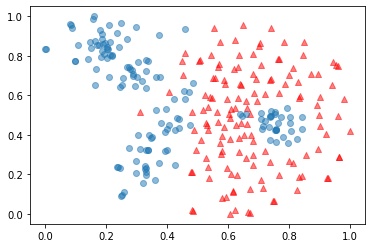

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

SIZE = len(testset)
train_r = np.array([data[0].numpy() for data in trainset])
r = np.array([data[0].numpy() for data in testset])
X = np.concatenate([gen_z, r], axis=0).reshape(2*SIZE, -1)
X_embed = TSNE(n_components=2).fit_transform(X)
X_embed = MinMaxScaler().fit_transform(X_embed)

plt.scatter(X_embed[:len(testset), 0], X_embed[:len(testset), 1], c='r', marker='^', alpha=0.5)
plt.scatter(X_embed[len(testset):, 0], X_embed[len(testset):, 1], alpha=0.5)
# plt.show()
plt.show()

In [16]:
def visualization(ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["tab:blue" for i in range(anal_sample_no)] + ["tab:orange" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 276 samples in 0.000s...
[t-SNE] Computed neighbors for 276 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 276 / 276
[t-SNE] Mean sigma: 1.161695
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.194767
[t-SNE] KL divergence after 300 iterations: 0.783387


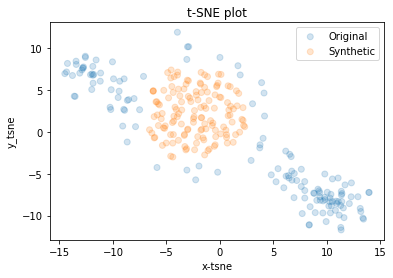

In [19]:
visualization(r, gen_z, 'tsne')

In [35]:
gen_z_t.shape

(15, 640, 2)